# Example 7

Meshing 8-node-isoparametric elements (second order incomplete quads). Shows use of surfacemarkers/elementmarkers to apply different properties to elements in different regions. 

In [3]:
import calfem.geometry as cfg
import calfem.mesh as cfm
import calfem.vis_mpl as cfv
import calfem.utils as cfu
import calfem.core as cfc

import numpy as np

In [4]:
%matplotlib notebook

## Problem variables

In [5]:
kx1 = 100
ky1 = 100
kx2 = 10
ky2 = 10
t = 1.0

# Gauss points or integration points 

n = 2 
ep = [t, n]

D1 = np.matrix([
    [kx1, 0.],
    [0., ky1]
])
D2 = np.matrix([
    [kx2, 0.],
    [0., ky2]
])

# markers 10 & 11 will be used to specify different regions with different 
# conductivity.

Ddict = {10 : D1, 11 : D2} 

## Define geometry

In [6]:
g = cfg.geometry()

### Add points

In [7]:
points = [
    [0,0], 
    [0,100], 
    [0,150], 
    [100,0], 
    [150,0], 
    [100,-100], 
    [150,-100]
]

for p in points:
    g.point(p)

### Add splines

In [8]:
g.spline([1,2], marker=2, elOnCurve=4)
g.spline([3,4], elOnCurve=4)
g.circle([1,0,3], elOnCurve = 10)
g.circle([2,0,4], elOnCurve = 10)
g.spline([3,5], elOnCurve = 6)
g.spline([5,6], marker=3, elOnCurve = 4)
g.spline([6,4], elOnCurve = 6)

### Add surfaces

In [10]:
g.structuredSurface([0,2,1,3], marker = 10)
g.structuredSurface([1,4,5,6], marker = 11)

## Generate mesh

In [12]:
el_type = 16 
dofs_per_node = 1 

mesh = cfm.GmshMesh(g, el_type, dofs_per_node) 

coords, edof, dofs, bdofs, elementmarkers = mesh.create()

## Solve problem

### Assemble system matrix

In [13]:
n_dofs = np.size(dofs)
ex, ey = cfc.coordxtr(edof, coords, dofs)

K = np.zeros([n_dofs,n_dofs])

for eltopo, elx, ely, elMarker in zip(edof, ex, ey, elementmarkers):

    # Calc element stiffness matrix: Conductivity matrix D is taken 
    # from Ddict and depends on which region (which marker) the element is in.

    Ke = cfc.flw2i8e(elx, ely, ep, Ddict[elMarker]) 
    cfc.assem(eltopo, K, Ke)

### Solving equation system

In [14]:
f = np.zeros([n_dofs,1])

bc = np.array([],'i')
bc_val = np.array([],'i')

bc, bc_val = cfu.applybc(bdofs,bc,bc_val,2,30.0)
bc, bc_val = cfu.applybc(bdofs,bc,bc_val,3,0.0)

a,r = cfc.solveq(K,f,bc,bc_val)

### Compute element forces

In [15]:
ed = cfc.extractEldisp(edof,a)

for i in range(np.shape(ex)[0]):
    es, et, eci = cfc.flw2i8s(ex[i,:], ey[i,:], ep, Ddict[elementmarkers[i]], ed[i,:])

## Visualise results

<IPython.core.display.Javascript object>


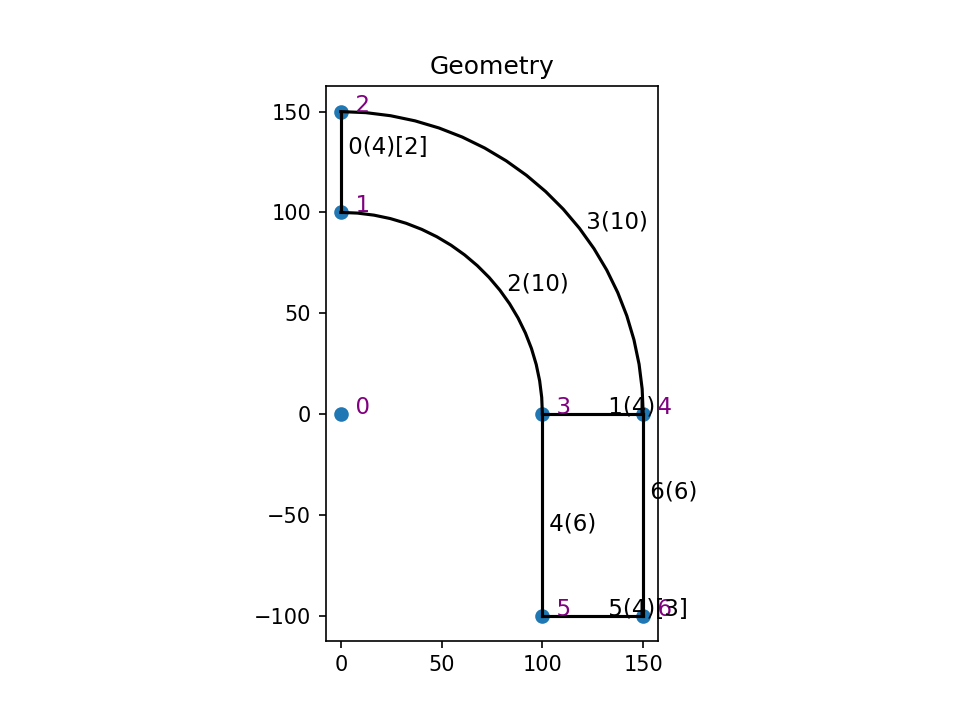

c:\Users\jonas\Development\calfem-python\calfem\vis_mpl.py:692: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  return np.asarray(np.vstack(T * M * CPs[j-1:j+3, :] for j in range(1, len(CPs)-2)))


In [16]:
cfv.figure()
cfv.draw_geometry(g, title="Geometry")

In [18]:
cfv.figure()
cfv.draw_mesh(coords, edof, dofs_per_node, el_type, filled=False)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


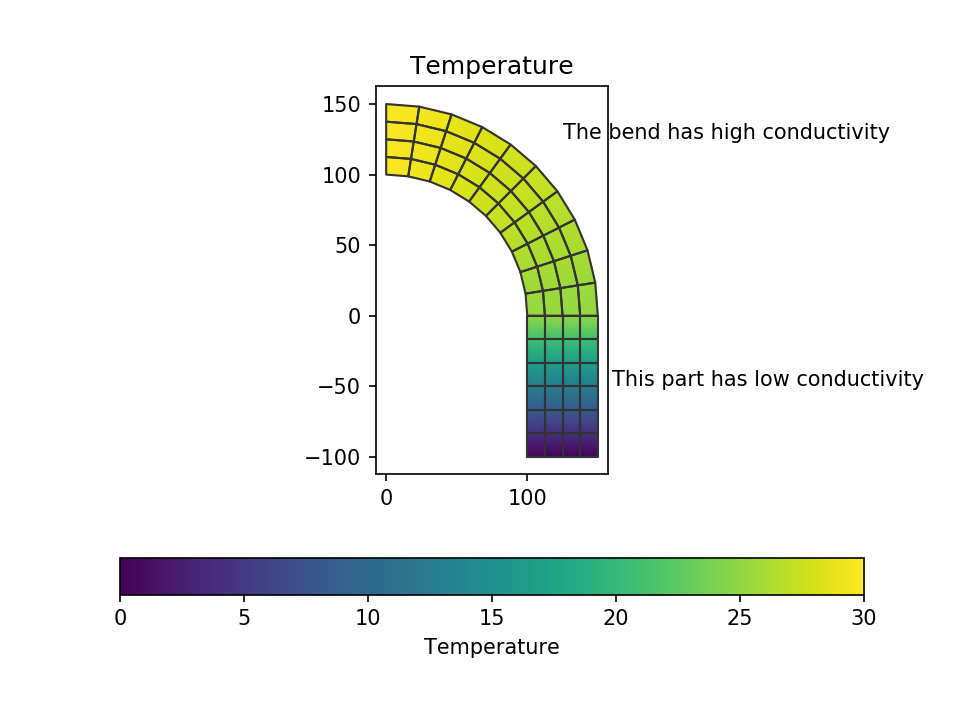

Text(160, -50, 'This part has low conductivity')

In [19]:
cfv.figure()
cfv.draw_nodal_values_shaded(a, coords, edof, title="Temperature", dofs_per_node=mesh.dofs_per_node, el_type=mesh.el_type, draw_elements=True)
cbar = cfv.colorbar(orientation="horizontal")
cbar.set_label("Temperature")

cfv.text("The bend has high conductivity", (125,125))
cfv.text("This part has low conductivity", (160,-50))